# Introductory CNN Model: MNIST Digits

----------------------------------

In this example, we will download the MNIST handwritten digits and create a simple CNN network to predict the digit category (0-9).

To start, we load the necessary libraries.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.python.framework import ops
ops.reset_default_graph()

Start a computational graph session and a saver session:

In [2]:
# Start a graph session
sess = tf.Session()


TensorFlow has a built in method for loading the MNIST data sets.  It checks to see if you have downloaded it before, and if not, downloads and saves the files for you.

In [3]:
# Load data
data_dir = 'temp'
mnist = read_data_sets(data_dir)

Extracting temp\train-images-idx3-ubyte.gz
Extracting temp\train-labels-idx1-ubyte.gz
Extracting temp\t10k-images-idx3-ubyte.gz
Extracting temp\t10k-labels-idx1-ubyte.gz


Now we convert the images to have a size of 28x28.  They are downloaded as a 1x784 array.

In [4]:
# Convert images into 28x28 (they are downloaded as 1x784)
train_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.train.images])
test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])

# Convert labels into one-hot encoded vectors
train_labels = mnist.train.labels
test_labels = mnist.test.labels

Now we set the model parameters as follows.

In [5]:
# Set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = train_xdata[0].shape[0]
image_height = train_xdata[0].shape[1]
target_size = max(train_labels) + 1
num_channels = 1 # greyscale = 1 channel
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 # NxN window for 1st max pool layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer
fully_connected_size1 = 100

Declare model placeholders.  Remember that we need placeholders for the training data and the evaluation data.

In [6]:
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

Here we declare model parameters.  For this model we will have two convolutional layers (each having filter size 4x4).  We follow this with two fully connected layers.

In [7]:
# Convolutional layer variables
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
                                               stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],
                                               stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

# fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],
                          stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32))
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size],
                                               stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

After we have the layer variables, we can create the model operations.

   (Convolutional layer 1) --> (ReLU 1) --> (Max Pool 1) -->


-->(Convolutional layer 2) --> (ReLU 2) --> (Max Pool 2) -->


-->(Fully Connected Layer 1) --> (Fully Connected Layer 2) --> Prediction.

#### iniciando a variavel saver para salvar a rede

In [8]:
saver = tf.train.Saver ()

In [9]:
# Initialize Model Operations
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    
    return(final_model_output)

model_output = my_conv_net(x_input)
test_model_output = my_conv_net(eval_input)

We will us the softmax cross entropy loss.

In [10]:
# Declare Loss Function (softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=y_target))

We also create a prediction and accuracy function for evaluation on the train and test set.

In [11]:
# Create a prediction function
prediction = tf.nn.softmax(model_output)
test_prediction = tf.nn.softmax(test_model_output)

# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])

Here, we will use the Momentum Optimizer with a learning rate of `0.005` and a decay rate of `0.9`.  Then we initialize our model variables.

In [12]:
# Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)

# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)


Now we can start training!

In [13]:
# Start training loop
train_loss = []
train_acc = []
test_acc = []
for i in range(generations):
    rand_index = np.random.choice(len(train_xdata), size=batch_size)
    rand_x = train_xdata[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = train_labels[rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if (i+1) % eval_every == 0:
        eval_index = np.random.choice(len(test_xdata), size=evaluation_size)
        eval_x = test_xdata[eval_index]
        eval_x = np.expand_dims(eval_x, 3)
        eval_y = test_labels[eval_index]
        test_dict = {eval_input: eval_x, eval_target: eval_y}
        test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(test_preds, eval_y)
        
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Generation # 5. Train Loss: 2.30. Train Acc (Test Acc): 15.00 (17.00)
Generation # 10. Train Loss: 2.16. Train Acc (Test Acc): 23.00 (23.20)
Generation # 15. Train Loss: 2.04. Train Acc (Test Acc): 43.00 (38.40)
Generation # 20. Train Loss: 1.96. Train Acc (Test Acc): 43.00 (44.80)
Generation # 25. Train Loss: 1.81. Train Acc (Test Acc): 57.00 (62.20)
Generation # 30. Train Loss: 1.49. Train Acc (Test Acc): 64.00 (66.00)
Generation # 35. Train Loss: 1.18. Train Acc (Test Acc): 73.00 (72.80)
Generation # 40. Train Loss: 0.99. Train Acc (Test Acc): 73.00 (75.80)
Generation # 45. Train Loss: 0.68. Train Acc (Test Acc): 79.00 (80.80)
Generation # 50. Train Loss: 0.65. Train Acc (Test Acc): 83.00 (74.60)
Generation # 55. Train Loss: 0.57. Train Acc (Test Acc): 86.00 (81.20)
Generation # 60. Train Loss: 0.50. Train Acc (Test Acc): 87.00 (84.80)
Generation # 65. Train Loss: 0.43. Train Acc (Test Acc): 84.00 (83.40)
Generation # 70. Train Loss: 0.42. Train Acc (Test Acc): 85.00 (87.80)
Generat

### Salvando os parametros treinados

In [14]:
os.chdir('save')
saver.save(sess, os.path.join(os.getcwd(), 'teste_save'))

'C:\\Users\\Tales\\algoritmos_fcs\\save\\teste_save'

Let's plot the loss and accuracies.

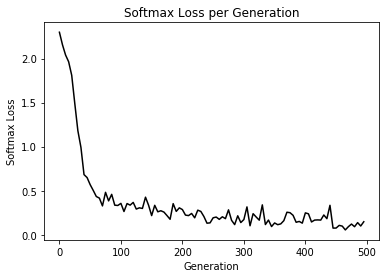

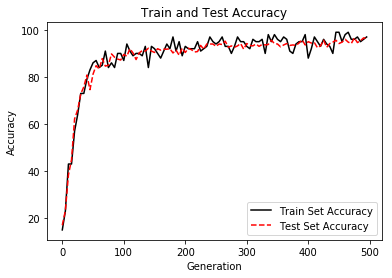

In [15]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(eval_indices, test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Let's see how our model runs on a test of 6 random examples.

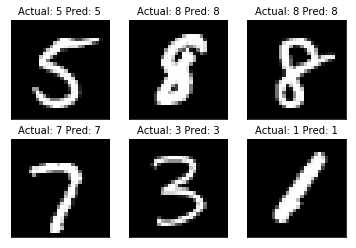

In [16]:
# Plot some samples
# Plot the 6 of the last batch results:
actuals = rand_y[0:6]
predictions = np.argmax(temp_train_preds,axis=1)[0:6]
images = np.squeeze(rand_x[0:6])

Nrows = 2
Ncols = 3
for i in range(6):
    plt.subplot(Nrows, Ncols, i+1)
    plt.imshow(np.reshape(images[i], [28,28]), cmap='Greys_r')
    plt.title('Actual: ' + str(actuals[i]) + ' Pred: ' + str(predictions[i]),
                               fontsize=10)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
plt.show()